In [1]:
from online_batches import online_batches
from matplotlib import pyplot as plt

In [44]:
import tensorflow as tf
import pandas as pd
import numpy as np


class ml_model:
    
    def __init__(self, data_batches) -> None:
        self.solar_model = tf.keras.models.load_model("saved_model/temp_Austin_solar_lstm3/")
        self.temp_model = tf.keras.models.load_model("saved_model/temp_Austin_temp_lstm3/")
        self.load_model = tf.keras.models.load_model("saved_model/load_cnn.h5")
        # split the data into inputs and targets
        freq = 30          # 1 point every 15 min
        step = int(60/freq)    # number of points in an hour
        past = 6*24*step    # will be using last 7 days of data
        future = 1*24*step  # to predict next 1 day
        self.scaling_const = 1000

        # I want to use a T-days window of input data for predicting target_class
        # It means I need to prepend (T-1) last train records to the 1st test window
        self.T = past  # my choice of the timesteps window
        self.pred_T = future
        self.austin_N = 6   # number of features
        self.load_N = 1     # number of load features
        self.LR = 1e-3      # learning rate of the gradient descent
        self.labels = data_batches.get_timestamps()
        self.temp_avg = pd.DataFrame({'predicted':  np.full(self.labels.shape[0], np.nan)},index=self.labels)
        self.solar_avg = pd.DataFrame({'predicted':  np.full(self.labels.shape[0], np.nan)},index=self.labels)
        self.load_avg = pd.DataFrame({'predicted':  np.full(self.labels.shape[0], np.nan)},index=self.labels)

  
            

    def predict(self, t, data_batches: online_batches):
        # Call predict method on the loaded model
        temp_X, temp_y, temp_scalar, solar_X, solar_y, solar_scalar, load_X, load_y, load_scalar = data_batches.get_online_training_data(t)
        temp_hat = self._predict(self.temp_model, temp_X, temp_y,self.austin_N, temp_scalar,self.temp_avg, t, 'temp')
        solar_hat = self._predict(self.solar_model, solar_X, solar_y,self.austin_N, solar_scalar, self.solar_avg, t, 'solar')
        load_hat = self._predict_load(self.load_model, load_X, load_y,self.load_N, load_scalar, self.load_avg, t)

        # need to divide solar by 1000 to conver to K(units)
        return temp_hat,solar_hat/1000,load_hat
    
    def _predict(self,model, X_test, y_test, N, scalar, avg_df, i, which):
        x = X_test.reshape(-1,self.T,N)  # a "new" input is available
        y_hat = model.predict_on_batch(x) # predict on the "new" input
        # averaged = np.mean(y_hat[:,3:6,:], axis=1)
        
        y = y_test.reshape(1,self.pred_T,1)   # a "new" label is available
        print(y.shape)
        model.train_on_batch(x, y)  # runs a single gradient update 

        predicted = scalar.inverse_transform(y_hat)
       
        index = self.labels[i:i+y_test.shape[0]]
       
        dff1 = pd.DataFrame({'predicted': predicted.squeeze()}, index=index)
        avg_df = avg_df.join(dff1, how='left', rsuffix=f'_{i}')
        if(which=='solar'):
            self.solar_avg = avg_df
        elif(which=='temp'):
            self.temp_avg = avg_df
        dff_avg = avg_df.iloc[i:i+self.pred_T]
        predicted = dff_avg.mean(axis=1)
        return predicted
    
    def _predict_load(self, model, X_test, y_test, N, scalar, avg_df, i):
        x = X_test[i:i+self.pred_T]
        preds = model.predict(x)
        predicted = self._clean_load_pred(preds)
    
        y = y_test[i:i+self.pred_T]  # a new label is available
        model.train_on_batch(x, y)  # runs a single gradient update 
        
        index = self.labels[i:i+self.pred_T]
       
        dff1 = pd.DataFrame({'predicted': predicted.squeeze()}, index=index)
        avg_df = avg_df.join(dff1, how='left', rsuffix=f'_{i}')
        self.load_avg = avg_df 

        dff_avg = avg_df.iloc[i:i+self.pred_T]
        predicted = dff_avg.mean(axis=1)
        return predicted

    
    def _clean_load_pred(self,arr):
        arr = np.where((arr >= 0.4) & (arr <= 0.8), 0.1, arr)
        arr = np.clip(arr, 0.091, np.inf)
        return arr



In [ ]:
ob = online_batches()

In [45]:
ml = ml_model(ob)

In [29]:
start = 16
t = ob.get_timestamps()
t[start:]

DatetimeIndex(['2023-01-18 00:05:00', '2023-01-18 00:35:00',
               '2023-01-18 01:05:00', '2023-01-18 01:35:00',
               '2023-01-18 02:05:00', '2023-01-18 02:35:00',
               '2023-01-18 03:05:00', '2023-01-18 03:35:00',
               '2023-01-18 04:05:00', '2023-01-18 04:35:00',
               ...
               '2023-04-10 19:05:00', '2023-04-10 19:35:00',
               '2023-04-10 20:05:00', '2023-04-10 20:35:00',
               '2023-04-10 21:05:00', '2023-04-10 21:35:00',
               '2023-04-10 22:05:00', '2023-04-10 22:35:00',
               '2023-04-10 23:05:00', '2023-04-10 23:35:00'],
              dtype='datetime64[ns]', name='datetime', length=3972, freq=None)

In [21]:
y_test = ob.get_y(0,'temp')
y_test

array([0.502, 0.488, 0.47 , 0.438, 0.402, 0.382, 0.366, 0.352, 0.344,
       0.338, 0.338, 0.34 , 0.332, 0.336, 0.342, 0.344, 0.342, 0.338,
       0.344, 0.342, 0.346, 0.346, 0.35 , 0.35 , 0.346, 0.35 , 0.354,
       0.344, 0.334, 0.334, 0.342, 0.34 , 0.28 , 0.272, 0.29 , 0.296,
       0.302, 0.334, 0.366, 0.378, 0.398, 0.404, 0.424, 0.42 , 0.432,
       0.442, 0.45 , 0.448])

In [25]:
y_test[0]

0.502

(1, 48, 1)
(1, 48, 1)
2/2 [==============================] - 0s 5ms/step


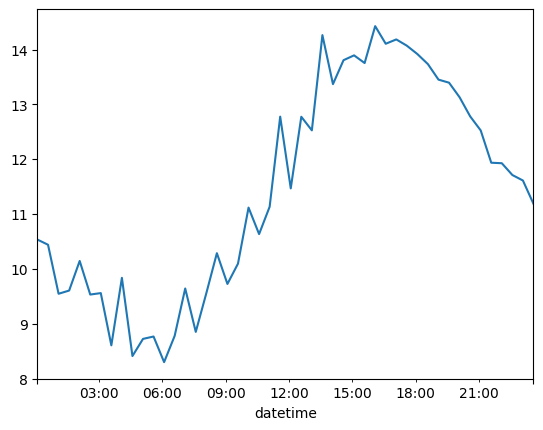

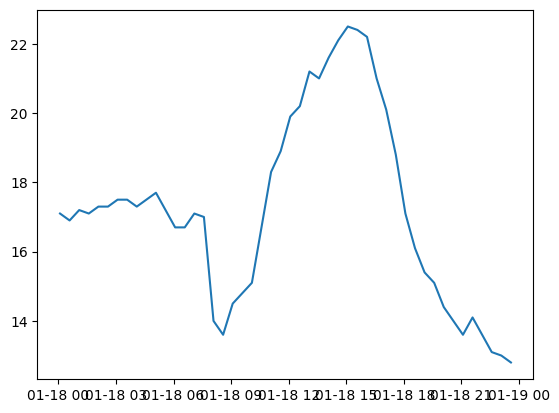

(1, 48, 1)
(1, 48, 1)
2/2 [==============================] - 0s 17ms/step


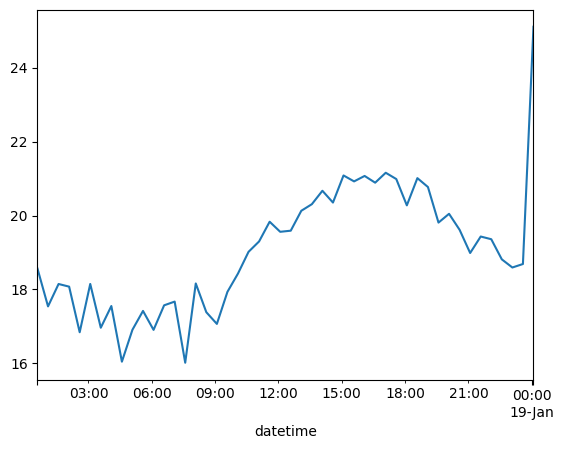

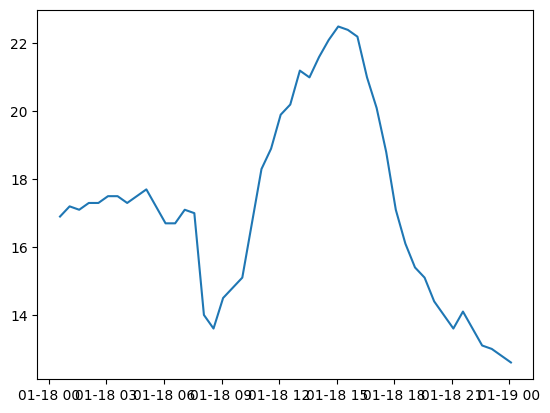

In [46]:
start = 16
scalar = ob.get_scalar_y("temp")
for i in range(start,start+2):
    T_out, Ins_PV, Load = ml.predict(i,ob)
    T_out.plot()
    plt.show()
    plt.plot(t[i:i+48],scalar.inverse_transform(ob.get_y(i,"temp")))
    plt.show()

In [ ]:
print(ob.data["solar"]["Y_test_batches"][:48])

In [ ]:
ob.get_timestamps()[:48]

In [ ]:
plt.plot(ob.get_timestamps()[:48], ob.data["solar"]["Y_test_batches"][:48][0])
plt.xticks(rotation=90, ha="right")